In [2]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
feature_A = "bmi"

### Korrelation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from Dashboard.data_preprocessing import load_and_preprocess_data
from Dashboard.model_adapter import ModelAdapter


X_train, X_test, y_train, y_test, task = load_and_preprocess_data("bike")


# Assuming 'category_column' is your categorical column
label_encoder = LabelEncoder()

# Then calculate the correlation matrix

adapter_initial = ModelAdapter(task)
adapter_initial.model.fit(X_train, y_train)
X_train_preprocessed = adapter_initial.model._preprocess_feature_matrix(X_train)


print(X_train_preprocessed)
# correlation_matrix = X_train.corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
# plt.show()



tensor([[-1.6222, -0.4003, -1.5424,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.1410, -1.0741,  0.1195,  ...,  0.0000,  1.0000,  0.0000],
        [-0.1238,  1.9322, -0.1921,  ...,  0.0000,  1.0000,  0.0000],
        ...,
        [ 1.4637, -1.0223,  1.5737,  ...,  0.0000,  1.0000,  0.0000],
        [-1.6222,  0.1180, -1.3346,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.1410,  1.0510,  0.1195,  ...,  0.0000,  1.0000,  1.0000]])


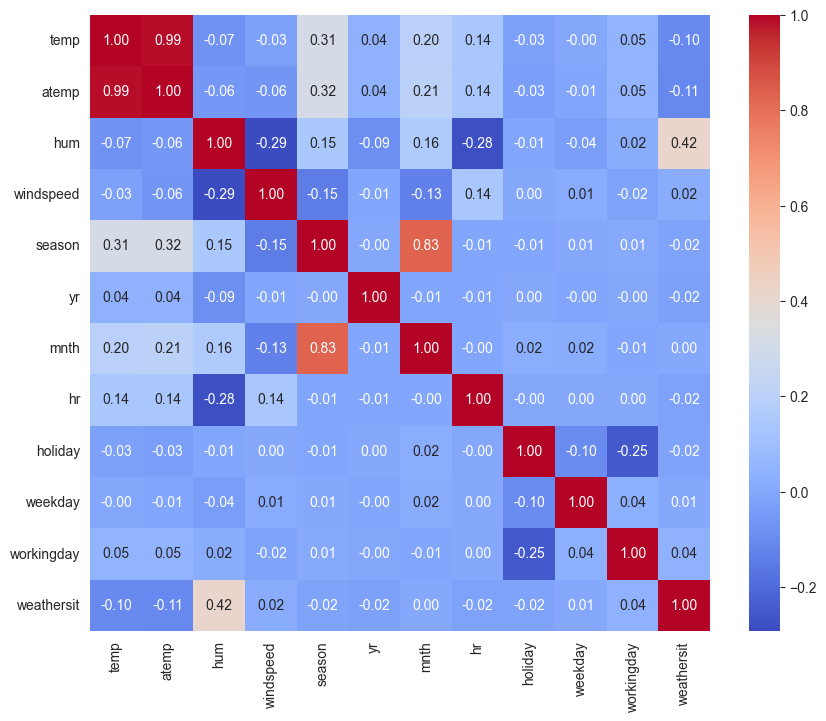

In [2]:
correlation_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [7]:
df_describe = pd.DataFrame(y_train)
df_describe.describe()

,0
count,13903.000000
mean,0.006141
std,1.004592
min,-1.039008
25%,-0.829511
50%,-0.256154
75%,0.510161
max,4.336222


### Kontrollgruppe

## Experiment 1

MSE Train: 0.47059960764395203, MSE Test: 0.4547642929721244


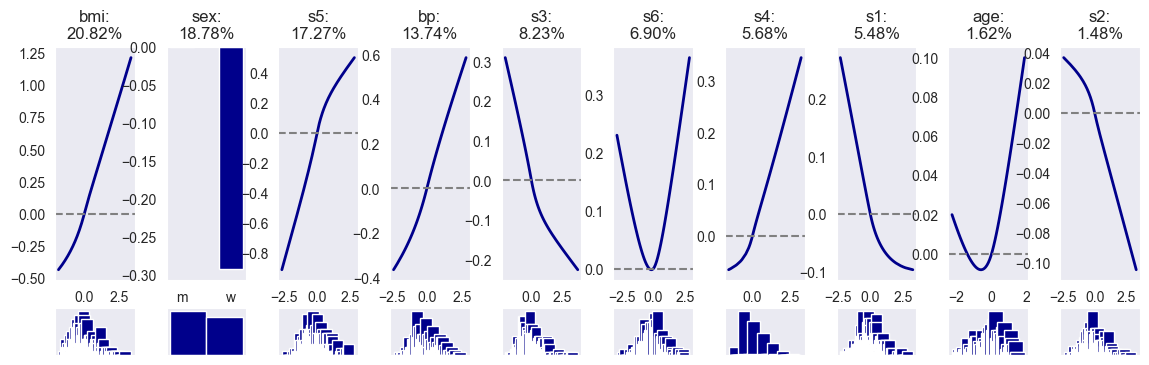

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score
from Dashboard.data_preprocessing import load_and_preprocess_data
from Dashboard.model_adapter import ModelAdapter
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score

X_train, X_val, y_train, y_val, task = load_and_preprocess_data()
#X_train = X_train[['s1', 's2']]

adapter_initial = ModelAdapter(task)
adapter_initial.model.fit(X_train, y_train)
y_train_pred = adapter_initial.model.predict(X_train)
y_val_pred = adapter_initial.model.predict(X_val)


mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_val, y_val_pred)
print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")


adapter_initial.model.plot_single(show_n=10)

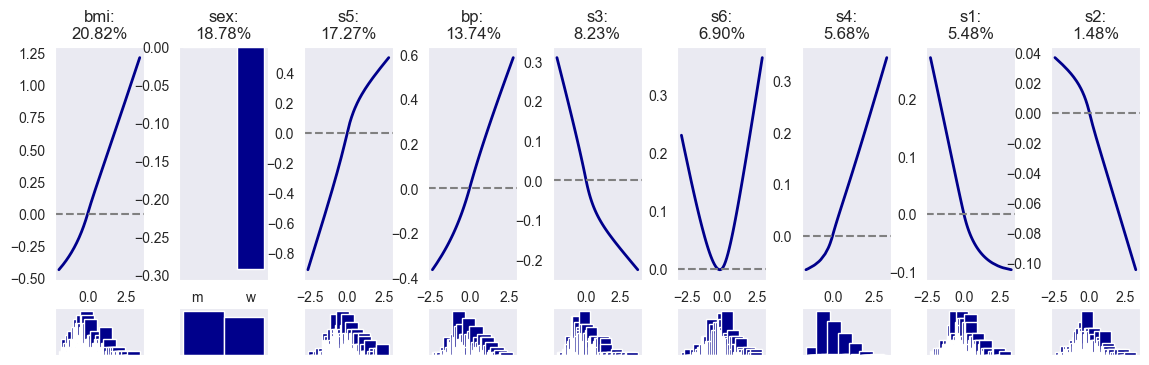

In [5]:
# Step 1: Get predictions for feature_1 (BMI)

feature_1 = "bmi"
shape_functions_dict = adapter_initial.model.get_shape_functions_as_dict()

i = adapter_initial.model.feature_names.index(feature_1)
feat_values = np.array(X_train[feature_1])
#adapter.model._get_pred_feature_1_of_i(i, np.array(X_train))
#y = torch.tensor(updated_data[feature]['y'], dtype=torch.float64)
if adapter_initial.model.task == "classification":
    pred_feature_1 = adapter_initial.model.init_classifier.coef_[0, i] * feat_values
else:
    pred_feature_1 = adapter_initial.model.init_classifier.coef_[i] * feat_values

if isinstance(pred_feature_1, np.ndarray):
    pred_feature_1 = torch.from_numpy(pred_feature_1).float()

for regressor, boost_rate in zip(adapter_initial.model.regressors, adapter_initial.model.boosting_rates):
    pred_feature_1 += (
        boost_rate
        * regressor.predict_single(torch.tensor(feat_values.reshape(-1, 1), dtype=torch.float), i).squeeze()
    ).cpu()

In [6]:
# Step 2: Adjust overall predictions by subtracting the predictions of feature_1
y_train_adjusted = y_train - np.array(pred_feature_1)
# Prepare new X column
X_train_except_feat_1 = X_train.drop(columns=[feature_1])



MSE Train: 0.4664780078636073


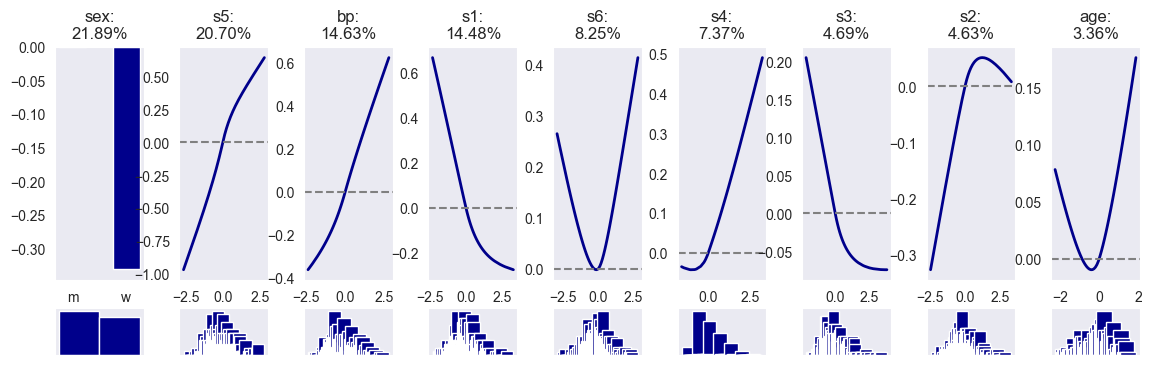

In [8]:
# Step 3:
# Retrain all other features with y_train_adjusted
adapter_control_group = ModelAdapter(task)
adapter_control_group.fit(X_train_except_feat_1, y_train_adjusted)
y_train_pred_adjusted= adapter_control_group.predict(X_train_except_feat_1)
#y_val_pred_adjusted = adapter_control_group.predict()
if task == "regression":
    mse_train_adjusted_feat_1 = mean_squared_error(y_train_adjusted, y_train_pred_adjusted)
    print(f"MSE Train: {mse_train_adjusted_feat_1}")
else:
    f1_train_adjusted_feat_1 = f1_score(y_train_adjusted, y_train_pred_adjusted, average='weighted')
    print(f"Train F1 Score: {f1_train_adjusted_feat_1}")

adapter_control_group.model.plot_single(show_n=10)

In [9]:
# Step 4: Calculate the normalilzed y values of the shape functions and calculate MSE
shape_functions_initial = adapter_initial.get_shape_functions_as_dict()
for function in shape_functions_initial:
    if function['datatype'] == 'numerical':
        y = function['y']
        normalized_y = (y - np.min(y)) / (np.max(y) - np.min(y))
        function['y_normalized'] = normalized_y


shape_functions_control_group = adapter_control_group.model.get_shape_functions_as_dict()
for function in shape_functions_control_group:
    if function['datatype'] == 'numerical':
        y = function['y']
        normalized_y = (y - np.min(y)) / (np.max(y) - np.min(y))
        function['y_normalized'] = normalized_y

mse_dict = {}
for function_initial in shape_functions_initial:
    for function in shape_functions_control_group:
        if function_initial['name'] == function['name'] and function_initial['datatype'] == 'numerical':
            mse = mean_squared_error(function_initial['y_normalized'], function['y_normalized'])
            mse_dict[function_initial['name']] = mse


In [10]:
mse_dict

{'age': 0.0067112185,
 'bp': 0.00016551791,
 's1': 0.0003713155,
 's2': 0.17490284,
 's3': 0.015391843,
 's4': 0.0049813087,
 's5': 0.0012989137,
 's6': 5.0995346e-05}

### Experimentgruppe

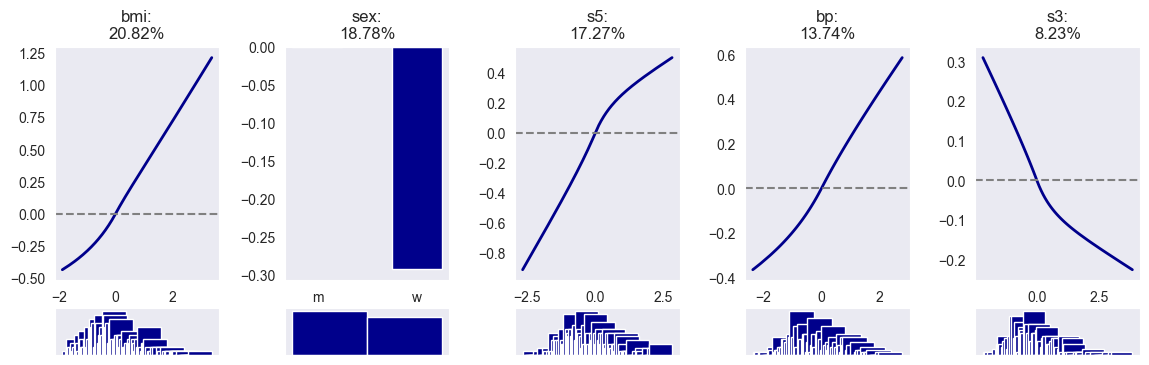

No synthetic points


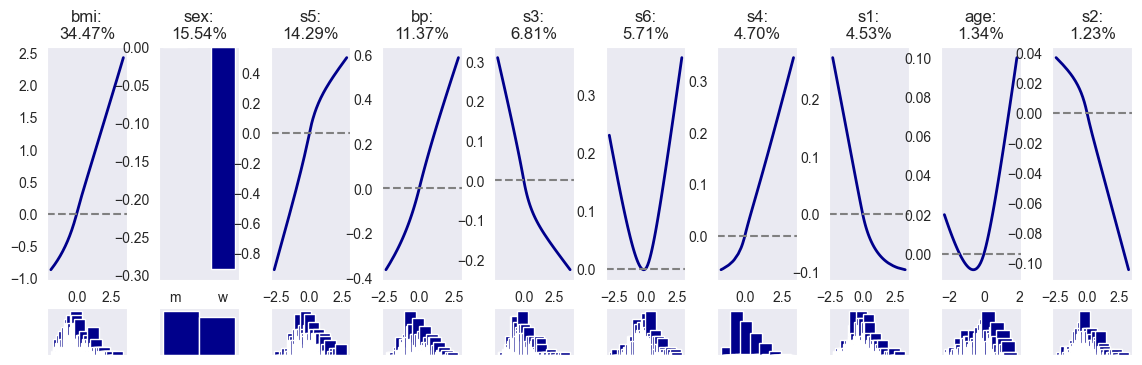

In [11]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score
from Dashboard.data_preprocessing import load_and_preprocess_data
from Dashboard.model_adapter import ModelAdapter
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score
from igann import IGANN

X_train, X_test, y_train, y_test, task = load_and_preprocess_data()
adapter = ModelAdapter(task)
adapter.fit(X_train, y_train)
y_train_pred = adapter.predict(X_train)
#y_test_pred = adapter.predict(X_test)
if task == "regression":
    mse_train = mean_squared_error(y_train, y_train_pred)
    #print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
else:
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    #print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")

adapter.model.plot_single(show_n=5)

feature_1 = "bmi"
shape_functions_dict = adapter.model.get_shape_functions_as_dict()
feature_current_state = {}
for feature in (shape_functions_dict):
    name = feature['name']
    y_value = feature['y']
    feature_current_state[name] = y_value
updated_data = {}
# Adjust feature 1 
features_to_change = [feature_1]
for feature in shape_functions_dict:
    name = feature['name']
    x_values = feature['x']
    if name in features_to_change:
        # Simulate user input (by setting negative values to 0); in flask app just use feature_current_state
        if feature["datatype"] == "categorical":
            user_input = -1.5
            feature_current_state[name][0] = -1.5
            y_values = np.array(feature_current_state[name])
            #y_values = {'x': x_values, 'y': np.where(np.array(feature_current_state[name]) < 0,
            #                                         -2, np.array(feature_current_state[name])), 'datatype': 'categorical'}
            #y_values = np.array(feature_current_state[name])
        else:
            #y_values = np.where(np.array(feature_current_state[name]) < 0, -10, feature_current_state[name])
            y_values = np.array(feature_current_state[name])
            #y_values = np.where(y_values < 0, -3, y_values)
            #updated_data[name] = {'x': x_values.tolist(), 'y': adjusted_y_values.tolist(),
            #                      'datatype': 'numerical'}
            synthetic_data_points_nr = 0
            new_x_values = []
            new_y_values = []
            #transformed_y_values = np.where(y_values < 0.8, 0.9, y_values)
            #transformed_y_values = np.where(y_values > 0, 1, y_values)
            transformed_y_values = np.where(y_values != 0, 2*y_values, y_values)

            #transformed_y_values = y_values
            if synthetic_data_points_nr > 0:
                for i in range(len(x_values) - 1):
                    new_x_values.append(x_values[i])
                    new_y_values.append(transformed_y_values[i])
                    # Calculate steps for synthetic points
                    x_step = (x_values[i + 1] - x_values[i]) / (synthetic_data_points_nr + 1)
                    y_step = (transformed_y_values[i + 1] - transformed_y_values[i]) / (synthetic_data_points_nr + 1)
                    #
                    for j in range(1, synthetic_data_points_nr + 1):
                        synthetic_x = x_values[i] + j * x_step
                        synthetic_y = transformed_y_values[i] + j * y_step if transformed_y_values[i] != -10 else -10
                        new_x_values.append(synthetic_x)
                        new_y_values.append(synthetic_y)
            #
            #    # Don't forget to add the last original point
                new_x_values.append(x_values[-1])
                new_y_values.append(transformed_y_values[-1])
                x_values = new_x_values
                y_values= new_y_values
            else:
                 y_values = transformed_y_values
                 print("No synthetic points")
            #                       'datatype': 'numerical'}
    else:
        # Use the original 'y' values from shape_functions_dict if there is no user change
        y_values = feature['y']

    if feature['datatype'] == 'numerical':
        updated_data[name] = {'x': x_values, 'y': y_values, 'datatype': 'numerical'}
    else:
        updated_data[name] = {'x': x_values, 'y': y_values, 'datatype': 'categorical'}


adapter = adapter.adapt(features_to_change, updated_data, "spline_interpolation")
adapter.plot_single(show_n=10)




In [38]:
adapter.feature_names

['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'sex_w']

MSE Train: 0.533324593271706


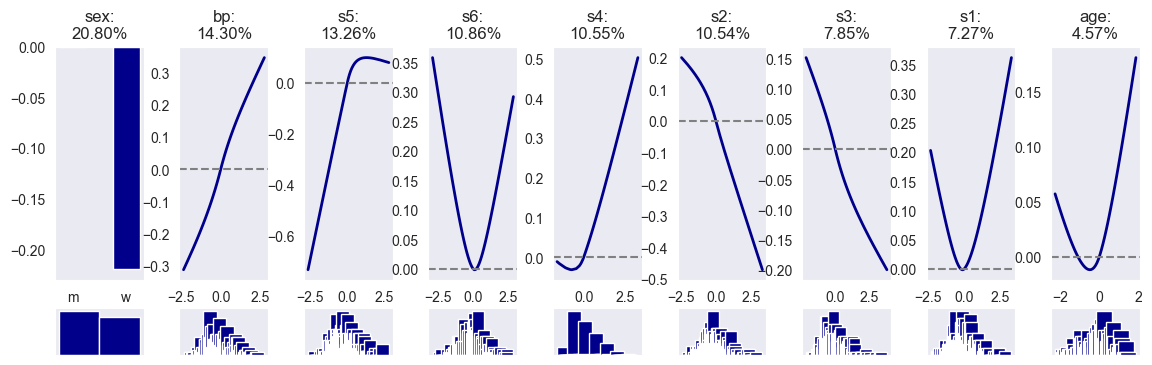

In [12]:
# Step 1: Get predictions for feature_1 (BMI)

feature_1 = "bmi"

i = adapter.feature_names.index(feature_1)
feat_values = np.array(X_train[feature_1])
#adapter.model._get_pred_feature_1_of_i(i, np.array(X_train))
#y = torch.tensor(updated_data[feature]['y'], dtype=torch.float64)
if adapter.task == "classification":
    pred_feature_1 = adapter.init_classifier.coef_[0, i] * feat_values
else:
    pred_feature_1 = adapter.init_classifier.coef_[i] * feat_values

if isinstance(pred_feature_1, np.ndarray):
    pred_feature_1 = torch.from_numpy(pred_feature_1).float()

for regressor, boost_rate in zip(adapter.regressors, adapter.boosting_rates):
    pred_feature_1 += (
            boost_rate
            * regressor.predict_single(torch.tensor(feat_values.reshape(-1, 1), dtype=torch.float), i).squeeze()
    ).cpu()
# Step 2: Adjust overall predictions by subtracting the predictions of feature_1
y_train_adjusted = y_train - np.array(pred_feature_1)
# Prepare new X column
X_train_except_feat_1 = X_train.drop(columns=[feature_1])

# Step 3:
# Retrain all other features with y_train_adjusted
adapter_adjusted_feat_1 = ModelAdapter(task)
adapter_adjusted_feat_1.fit(X_train_except_feat_1, y_train_adjusted)
y_train_pred_adjusted = adapter_adjusted_feat_1.predict(X_train_except_feat_1)
#y_val_pred_adjusted = adapter_adjusted_feat_1.predict()
if task == "regression":
    mse_train_adjusted_feat_1 = mean_squared_error(y_train_adjusted, y_train_pred_adjusted)
    print(f"MSE Train: {mse_train_adjusted_feat_1}")
else:
    f1_train_adjusted_feat_1 = f1_score(y_train_adjusted, y_train_pred_adjusted, average='weighted')
    print(f"Train F1 Score: {f1_train_adjusted_feat_1}")

adapter_adjusted_feat_1.model.plot_single(show_n=10)

In [46]:
# Step 4: Calculate the normalilzed y values of the shape functions and calculate MSE
shape_functions_initial = adapter.get_shape_functions_as_dict()
for function in shape_functions_initial:
    if function['datatype'] == 'numerical':
        y = function['y']
        normalized_y = (y - np.min(y)) / (np.max(y) - np.min(y))
        function['y_normalized'] = normalized_y


shape_functions_adjusted_feat_1 = adapter_adjusted_feat_1.model.get_shape_functions_as_dict()
for function in shape_functions_adjusted_feat_1:
    if function['datatype'] == 'numerical':
        y = function['y']
        normalized_y = (y - np.min(y)) / (np.max(y) - np.min(y))
        function['y_normalized'] = normalized_y

mse_dict_adjusted = {}
for function_initial in shape_functions_initial:
    for function in shape_functions_adjusted_feat_1:
        if function_initial['name'] == function['name'] and function_initial['datatype'] == 'numerical':
            mse = mean_squared_error(function_initial['y_normalized'], function['y_normalized'])
            mse_dict_adjusted[function_initial['name']] = mse

print(mse_dict_adjusted)

{'age': 0.001483735, 'bp': 0.00456062, 's1': 0.133168, 's2': 0.0011115202, 's3': 0.010949042, 's4': 0.007041143, 's5': 0.03307576, 's6': 0.023752993}


## Experiment 2

In [29]:
# Metrics to quantify the change
if task == "regression":
    main_metric = mse_train - mse_train_adjusted_feat_1
else:
    main_metric = f1_train - f1_train_adjusted_feat_1
print(f"Differenz in MSE or f1: {main_metric}")
shape_functions_dict_adjusted_feat_1 = adapter_adjusted_feat_1.get_shape_functions_as_dict()

correlations_with_feature_1 = correlation_matrix[feature_1]
correlations_with_feature_1 = correlations_with_feature_1.drop(feature_1)
results_columns = ['metadata'] + list(correlations_with_feature_1.index)  # Correlation indices as columns
results_df = pd.DataFrame(columns=results_columns)
results_df.loc[0] = ["Correlations"] + correlations_with_feature_1.tolist()



comparison_results = []

# Iterate through the original dictionary
for original_feature in shape_functions_dict:
    # Skip 'bmi' feature
    if original_feature['name'] == feature_1:
        continue
    
    # Find corresponding feature in the adjusted dictionary
    adjusted_feature = next((item for item in shape_functions_dict_adjusted_feat_1 if item['name'] == original_feature['name']), None)
    
    # Continue if the feature is not found in the adjusted dictionary
    if not adjusted_feature:
        continue
    
    # Calculate average of y values for both features
    avg_y_original = sum(original_feature['y']) / len(original_feature['y'])
    avg_y_adjusted = sum(adjusted_feature['y']) / len(adjusted_feature['y'])
    
    # Calculate the most distant points by finding the maximum absolute difference between corresponding y values
    max_diff = max(abs(o - a) for o, a in zip(original_feature['y'], adjusted_feature['y']))
    
    # Compare avg_effect
    avg_effect_diff = adjusted_feature['avg_effect'] - original_feature['avg_effect']
    
    # Store the comparison results
    comparison_results.append({
        'feature': original_feature['name'],
        'avg_y_original': avg_y_original,
        'avg_y_adjusted': avg_y_adjusted,
        'max_diff_y': max_diff,
        'avg_effect_diff': avg_effect_diff,
    })

new_row = {'metadata': 'Avg Effect Diff'}
max_diff_row = {'metadata': 'Max Diff Y'}

for result in comparison_results:
    feature = result['feature']
    avg_effect_diff = result['avg_effect_diff']
    max_diff = result['max_diff_y']
    new_row[feature] = avg_effect_diff
    max_diff_row[feature] = max_diff
    # For features not in comparison_results, set to None or another placeholder value
    for col in results_df.columns:
        if col not in new_row:
            new_row[col] = None
        if col not in max_diff_row:
            max_diff_row[col] = None
new_row_df = pd.DataFrame([new_row])
max_diff_row_df = pd.DataFrame([max_diff_row])

# Append the new row to the DataFrame
results_df = pd.concat([results_df, new_row_df], ignore_index=True)
results_df = pd.concat([results_df, max_diff_row_df], ignore_index=True)
results_df
dataset="diabetes"
effect="with_effec"


path = os.path.join(os.getcwd(), f"freeze_weights_{dataset}_{effect}.csv")

results_df.to_csv(path, decimal=',', index=False)

Differenz in MSE or f1: -0.0035475671249475815
